# 835 Final Project

In [12]:
!wget https://raw.githubusercontent.com/HobbitLong/SupContrast/refs/heads/master/losses.py

--2024-12-05 12:57:33--  https://raw.githubusercontent.com/HobbitLong/SupContrast/refs/heads/master/losses.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4137 (4.0K) [text/plain]
Saving to: ‘losses.py.1’

losses.py.1         100%[===================>]   4.04K  --.-KB/s    in 0s      

2024-12-05 12:57:34 (28.6 MB/s) - ‘losses.py.1’ saved [4137/4137]



In [2]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms.functional as vF
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision.transforms import v2
from torchvision.models import mobilenet_v2, mobilenet_v3_large, vgg19, vgg16, resnet50, resnet18
from timm.models.swin_transformer import SwinTransformer
from sklearn.linear_model import LinearRegression
import kagglehub
import numpy as np
import os
from PIL import Image
from matplotlib import pyplot as plt
from sklearn.metrics import r2_score
from losses import SupConLoss
from torch.nn import TripletMarginLoss
import random

c:\Users\tsope\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
class ImageMask():
  def __init__(self, sz : tuple, fit : bool = True)->None:
    """
    Args:
        sz (tuple): Size of image
        fit (bool, optional): Fit diameter to smaller dimensions of sz
    """
    self.height = sz[0]
    self.width  = sz[1]
    self.radius = (self.height if self.height < self.width else self.width) / 2

    y, x = np.ogrid[:self.height, :self.width]

    # Calculate the center of the circle
    center_y, center_x = self.height // 2, self.width // 2

    # Create the mask for the circle
    distance_from_center = (y - center_y)**2 + (x - center_x)**2
    self.mask = distance_from_center <= self.radius**2

    self.mask = torch.tensor(self.mask)

  def __call__(self, image):
    mask = self.mask
    if len(image.shape) == 3:
      mask = mask.unsqueeze(0)

    return image * mask

class RandomCrop():
  def __init__(self, sz : tuple, depth : int = 1)->None:
    """
    Args:
        sz (tuple): Size of cropped image
        depth (int, optional): Returns # of randomly cropped images
    """
    assert depth > 0
    self.depth = depth
    self.sz    = sz

    self.cropper = torchvision.transforms.RandomCrop(self.sz)

  def __call__(self, image):
    if self.depth == 1:
      return self.cropper(image)

    # For depth > 1, apply cropping multiple times
    crops = [self.cropper(image) for _ in range(self.depth)]
    # Stack the crops along a new dimension to get shape (D, S, S)
    return torch.stack(crops)

class GaussianNoise():
  def __init__(self, mean : float | list | tuple = 0.0, sigma : float | list | tuple = 1.0, clamp : float = 1.0, mode : int = 0)->None:
    """
    Args:
        mean (float, list, optional): mean of gaussian distribution
        sigma (float, list, optional): standard deviation of gaussian distribution
        mode (int, optional): Random (slower) or Iterative (faster)
    """
    if isinstance(mean, tuple):
      self.means = np.linspace(mean[0], mean[1], 16)
    else:
      self.means  = np.array(mean)

    if isinstance(sigma, tuple):
      self.sigmas = np.linspace(sigma[0], sigma[1], 16)
    else:
      self.sigmas = np.array(sigma)

    # Pair up as [N, mean , sigma]
    self.pairs = np.array(np.meshgrid(self.means, self.sigmas)).T.reshape(-1, 2)
    self.samples = len(self.pairs)
    self.mode = mode
    self.idx = 0
    self.clamp = clamp

  def __call__(self, image):
    if self.mode == 0:
      idx = torch.randint(0, self.samples, (1,)).item()  # Random selection
    else:
      idx = self.idx
      self.idx += 1 # iterate idx

    params = self.pairs[idx % self.samples,:]  # Cycle through angles

    # Add Gaussian noise to the input tensor
    noisy_tensor = image + torch.normal(mean=params[0], std=params[1], size=image.size())

    noisy_tensor = torch.clamp(noisy_tensor, 0.0, self.clamp)
    return noisy_tensor

class RandomFlip():
  def __init__(self, prob: float = 0.5):
    self.prob = prob

  def __call__(self, image):
    decision = torch.rand(1).item()
    if decision < (self.prob / 2):
      image = vF.vflip(image)
    elif decision < (self.prob):
      image = vF.hflip(image)
    
    return image

class RandomRotationTensor():
  def __init__(self, degrees : float | tuple | int, samples : int = 64, mode : int = 0)->None:
    """
    Args:
        degress (float, tuple): If float or int, then we use sample from -x to x. If it is a tuple, it is (min, max)
        samples (int, optional): Number of samples to select from (the precision is (stop - start)/samples)
    """
    if isinstance(degrees, float) or isinstance(degrees, int):
      start = -degrees
      stop  =  degrees

    if isinstance(degrees, tuple):
      start = degrees[0]
      stop  = degrees[1]

    self.degrees = np.linspace(start=start, stop=stop, num=samples)

    self.samples = samples
    self.mode    = mode
    self.idx     = 0

  def __call__(self, image):
      if self.mode == 0:
        idx = torch.randint(0, self.samples, (1,)).item()  # Random selection
      else:
        idx = self.idx
        self.idx += 1 # iterate idx

      angle = self.degrees[idx % self.samples]  # Cycle through angles
      return torchvision.transforms.functional.rotate(image, angle)

class MultiView():
  def __init__(self, transforms : any, n_views : int = 10):
    self.n_views = n_views
    self.transforms = transforms

  def __call__(self, image):
    if self.n_views == 1:
      return self.transforms(image)

    # For depth > 1, apply cropping multiple times
    views = [self.transforms(image) for _ in range(self.n_views)]
    # Stack the crops along a new dimension to get shape (D, S, S)
    return torch.stack(views)
  
class RandomCut():
  def __init__(self, sz : tuple, prob : float = 0.5):
    # randomly selects a portion of the image to cut
    self.sz = sz
    self.prob = prob

  def __call__(self, image):
    x = random.randint(0, 126-self.sz[0])
    y = random.randint(0, 126-self.sz[1])

    h = random.randint(10, self.sz[0])
    w = random.randint(10, self.sz[1])

    decision = torch.rand(1).item()
    if decision < self.prob:
      image[0, x:x+h, y:y+w] = 0
    return image

class CustomDataset(Dataset):
    def __init__(self, folder_path, transform=None):
        """
        Args:
            folder_path (str): Path to the dataset folder.
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        self.folder_path  = folder_path
        self.transform    = transform
        self.image_paths  = []
        self.images       = []
        self.temperatures = []
        self.raw          = False

        for filename in sorted(os.listdir(folder_path)):
            if filename.endswith(".tiff"):
                image_path = os.path.join(folder_path, filename)
                self.image_paths.append(image_path)
                self.images.append(np.array(Image.open(image_path)))
                temperature = float(filename.split('_')[-1].replace('C.tiff', ''))
                self.temperatures.append(temperature)

        self.temperatures = torch.tensor(self.temperatures, dtype=torch.float32)
        self.images       = torch.tensor(np.array(self.images))

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        # Load image
        image       = self.images[idx]
        temperature = self.temperatures[idx]

        if not self.raw:
          if self.transform is not None:
            image = self.transform(image)

        return image, temperature

    def numpy(self, raw : bool = True):
      # get as numpy array (after transforms)
      X = []
      y = []
      prev = self.raw
      self.raw = raw
      for i in range(len(self.images)):
        image, temperature = self.__getitem__(i)

        X.append(image.cpu().detach().numpy())
        y.append(temperature.cpu().detach().numpy())

      self.raw = prev
      return np.array(X), np.array(y)

### Create dataset

In [6]:
# Load Kaggle dataset
path = kagglehub.dataset_download("juanda220485/synthetic-dataset-of-speckle-images")
print("Path to dataset files:", path)


# add randomized rotation
dataset = CustomDataset(path, transform=torchvision.transforms.Compose([
    MultiView(torchvision.transforms.Compose([
        lambda x : x.unsqueeze(0),
        GaussianNoise(mean=0.0, sigma=(1, 15), clamp=255),
        lambda x : x / 255.0,
        ImageMask(sz=(126, 126)),
        RandomRotationTensor(degrees=360, samples=128),
        RandomFlip(prob=0.667),
        RandomCut((64, 64))
    ]), n_views=10)
])
)

Path to dataset files: C:\Users\tsope\.cache\kagglehub\datasets\juanda220485\synthetic-dataset-of-speckle-images\versions\1


### View 10 images in dataset

<>:7: SyntaxWarning: invalid escape sequence '\d'
<>:7: SyntaxWarning: invalid escape sequence '\d'
C:\Users\tsope\AppData\Local\Temp\ipykernel_17400\3465962608.py:7: SyntaxWarning: invalid escape sequence '\d'
  plt.title(f"{temperature.item():.1f}$\degree$ C")


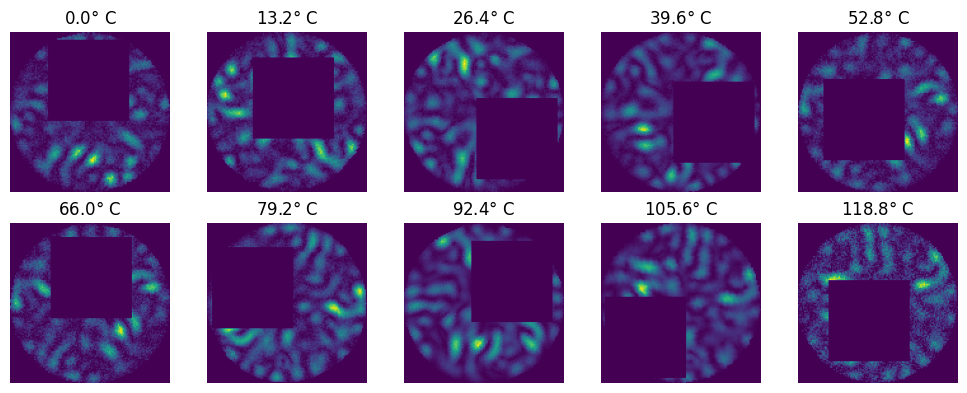

In [17]:
plt.figure(figsize=(10,4))
for i in range(10):
    plt.subplot(2, 5, 1 + i)
    image_tensor, temperature = dataset[66*i]
    image_np = image_tensor.numpy().squeeze()[1]
    img=plt.imshow(image_np)
    plt.title(f"{temperature.item():.1f}$\degree$ C")
    plt.axis('off')

plt.tight_layout()
plt.show()

### Visualize spatial FFT

<>:10: SyntaxWarning: invalid escape sequence '\d'
<>:10: SyntaxWarning: invalid escape sequence '\d'
C:\Users\tsope\AppData\Local\Temp\ipykernel_12940\2088889190.py:10: SyntaxWarning: invalid escape sequence '\d'
  plt.title(f"Log-Magnitude: {temperature.item():.1f}$\degree$ C")


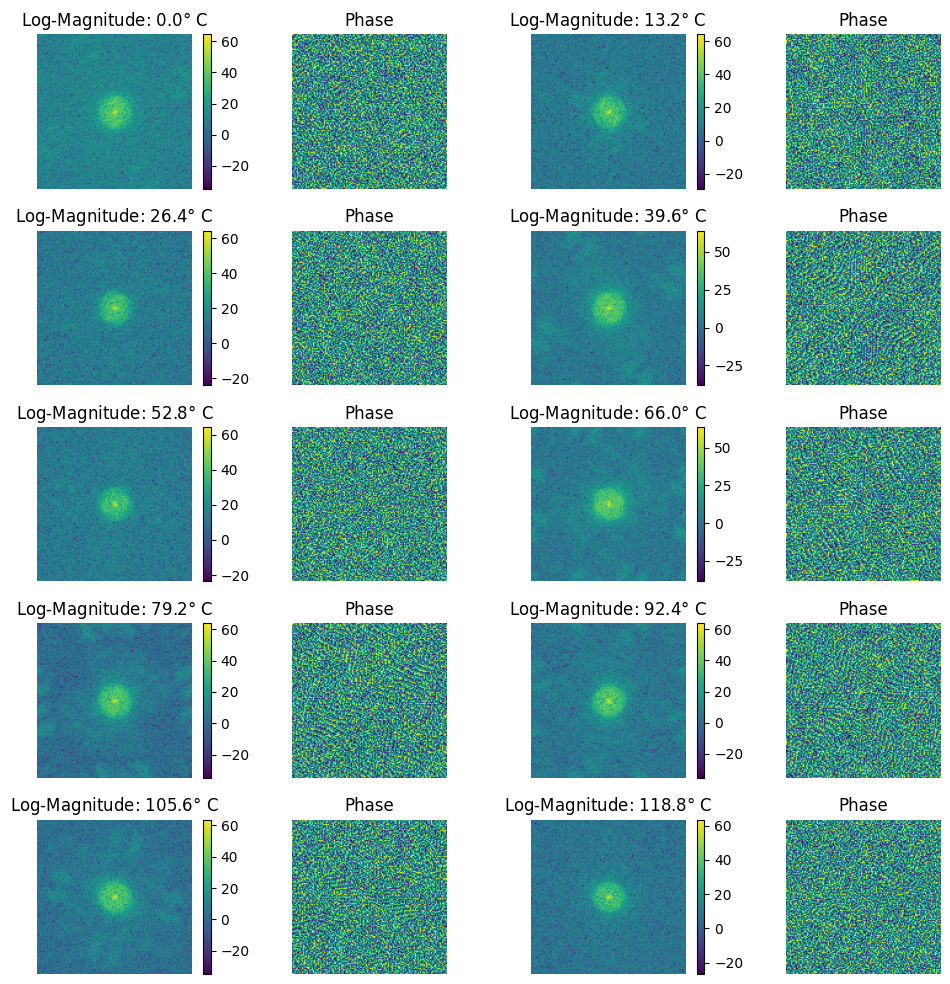

In [37]:
plt.figure(figsize=(10,10))
for i in range(0,10*2,2):
    plt.subplot(5, 4, 1 + i)
    image_tensor, temperature = dataset[66*(i//2)]
    image_np = image_tensor.numpy().squeeze()[0]
    ff = np.fft.fftshift(np.fft.fft2(image_np))

    m = 10*np.log10(np.abs(ff)**2)
    img=plt.imshow(m)
    plt.title(f"Log-Magnitude: {temperature.item():.1f}$\degree$ C")
    plt.axis('off')
    plt.colorbar()

    plt.subplot(5, 4, 1 + i + 1)
    a = np.angle(ff) + 3.1415   # shift from (-pi, pi) to (0, 2pi)
    img=plt.imshow(a)
    plt.title(f"Phase")
    plt.axis('off')

plt.tight_layout()
plt.show()

### Plot correlation w.r.t to 0.0 °C

<>:8: SyntaxWarning: invalid escape sequence '\d'
<>:9: SyntaxWarning: invalid escape sequence '\d'
<>:8: SyntaxWarning: invalid escape sequence '\d'
<>:9: SyntaxWarning: invalid escape sequence '\d'
C:\Users\tsope\AppData\Local\Temp\ipykernel_12940\1578246480.py:8: SyntaxWarning: invalid escape sequence '\d'
  plt.title("Similarity with reference image $0.0\degree C$")
C:\Users\tsope\AppData\Local\Temp\ipykernel_12940\1578246480.py:9: SyntaxWarning: invalid escape sequence '\d'
  plt.xlabel("Temperature $[\degree C]$")


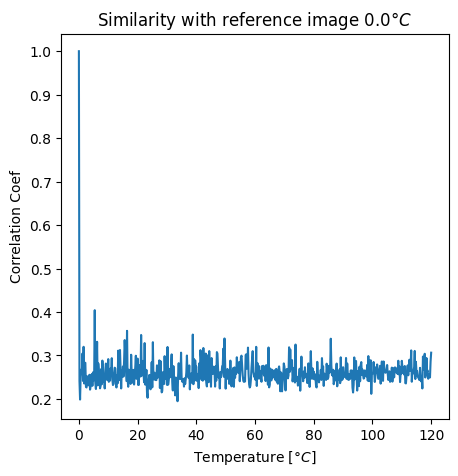

In [38]:
X, y = dataset.numpy(raw=False)
X = X.reshape(X.shape[0], np.prod(X.shape[1:]))
X = X - X.mean(axis=1, keepdims=True)
correlations = np.array([np.corrcoef(X[0,:], X[i,:])[0, 1] for i in range(X.shape[0])])

plt.figure(figsize=[5,5])
plt.plot(y, correlations)
plt.title("Similarity with reference image $0.0\degree C$")
plt.xlabel("Temperature $[\degree C]$")
plt.ylabel("Correlation Coef")
plt.show()

### Model
Model architecture based on TractoSCR

In [8]:
class SupConModel(nn.Module):
  def __init__(self, feature_dim : int = 128, device : str = "cpu")->None:
    super(SupConModel, self).__init__()
    self.backbone = resnet18(pretrained=True)
    self.backbone.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
    self.backbone.fc    = nn.Identity()
    self.linear = nn.Linear(512, 512)
    self.encoder = nn.Sequential(
      self.backbone,
      self.linear
    ).to(device)

    self.projector = nn.Sequential(
      nn.ReLU(inplace=True),
      nn.Linear(512, feature_dim),
    ).to(device)

  def forward(self, X):
    X = self.encoder(X)
    X = F.normalize(self.projector(X), dim=1)

    return X

class PairDet:
  def __init__(self, threshold : float = 1.0):
    self.T = threshold

  def __call__(self, y : torch.Tensor)->torch.Tensor:
    # A positive pair is when |yi - yj| <= T, were i, j in N
    # This returns a square matrix of (N, N) where
    # each row is an image, and each column where Aij = 1 is a positive pair
    #

    # replicate y, such that [y, y, ..., y] for N columns
    N  = len(y)
    Y  = y.expand(-1, N)
    Q  = torch.abs(Y - Y.T) <= self.T

    return Q

### Model training

In [13]:
# Hyperparameters
batch_size  = 128
epochs      = 150
lr          = 1e-4
split_ratio = 0.9   # %
device      = "cuda:0"
views       = 5
features_dim = 64

sz = (126, 126)
dataset = CustomDataset(path, transform=torchvision.transforms.Compose([
    MultiView(torchvision.transforms.Compose([
        lambda x : x.unsqueeze(0),
        GaussianNoise(mean=0.0, sigma=(1, 15), clamp=255),
        lambda x : x / 255.0,
        ImageMask(sz=(126, 126)),
        RandomRotationTensor(degrees=360, samples=128),   # Basic Augmentations

        RandomFlip(prob=0.667), # Additional Augmentations
        RandomCut((96, 96)),
    ]), n_views=4)
])
)

# Get the total size of the dataset
dataset_size = len(dataset)

# Calculate sizes for training and validation splits
train_size = int(split_ratio * dataset_size)
val_size = dataset_size - train_size

# Perform the split
generator1 = torch.Generator().manual_seed(42)
train_dataset, val_dataset = random_split(dataset, [train_size, val_size], generator=generator1)

# Create DataLoaders for training and validation
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True )
val_loader   = DataLoader(val_dataset  , batch_size=batch_size, shuffle=False)

supconmodel = SupConModel(features_dim, device).to(device)
optimizer   = torch.optim.Adam(supconmodel.parameters(), lr=lr,)
pdr         = PairDet(threshold = 1)
lossfn      = SupConLoss(base_temperature=0.001, temperature=0.01)

for epoch in range(epochs):
  supconmodel.train()
  print(f'########################################')
  print(f'Epoch: {epoch+1}')

  losses = 0
  count  = 0
  for images, temperatures in train_loader:
    N      = images.shape[0]
    V      = images.shape[1]
    images = images.to(device).reshape(N * V, 1, sz[0], sz[1])
    temperatures = temperatures.to(device).unsqueeze(1) #.expand(-1, V).reshape(N * V, 1)
    ##
    ##
    ##
    pairs = pdr(temperatures).to(device)
    proj  = supconmodel(images).reshape(N, V, features_dim)
    loss  = lossfn(proj, mask=pairs)

    # Backpropagation and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    losses += loss.cpu().detach().numpy()
    count  += 1
    print(f'*', end='')
  print('\n')
  print(f'Loss: {losses / count}')

########################################
Epoch: 1
*****

Loss: 102.08883209228516
########################################
Epoch: 2
*****

Loss: 63.229942321777344
########################################
Epoch: 3
*****

Loss: 59.484474182128906
########################################
Epoch: 4
*****

Loss: 57.89499969482422
########################################
Epoch: 5
*****

Loss: 56.73134918212891
########################################
Epoch: 6
*****

Loss: 54.617027282714844
########################################
Epoch: 7
*****

Loss: 54.091399383544925
########################################
Epoch: 8
*****

Loss: 53.25361557006836
########################################
Epoch: 9
*****

Loss: 51.75930404663086
########################################
Epoch: 10
*****

Loss: 51.29252395629883
########################################
Epoch: 11
*****

Loss: 50.389103698730466
########################################
Epoch: 12
*****

Loss: 49.70119018554688
###################

In [16]:
torch.save(supconmodel, "supervised_contrastive_encoder.pth")

### Fine-tuning

In [28]:
class RegressionModel(torch.nn.Module):
  def __init__(self, supconmodel : SupConModel, device : str = 'cpu')->None:
    super(RegressionModel, self).__init__()
    self.encoder = supconmodel.encoder

    for param in self.encoder.parameters():
      param.requires_grad = False

    self.head = nn.Sequential (
      nn.Linear(512, 256),
      nn.ReLU(),
      nn.Linear(256, 1),
    ).to(device)

  def forward(self, X):
    with torch.no_grad():
      X = self.encoder(X)
    X = self.head(X)

    return X

In [29]:
batch_size  = 64
epochs      = 200
lr          = 1e-3
split_ratio = 0.9   # %
device      = "cuda:0"
views       = 5
features_dim = 64

dataset = CustomDataset(path, transform=torchvision.transforms.Compose([
    MultiView(torchvision.transforms.Compose([
        lambda x : x.unsqueeze(0),
        GaussianNoise(mean=0.0, sigma=(1, 15), clamp=255),
        lambda x : x / 255.0,
        ImageMask(sz=(126, 126)),
        RandomRotationTensor(degrees=360, samples=128),
    ]), n_views=1)
])
)

# Get the total size of the dataset
dataset_size = len(dataset)

# Calculate sizes for training and validation splits
train_size = int(split_ratio * dataset_size)
val_size = dataset_size - train_size

# Perform the split
generator1 = torch.Generator().manual_seed(42)
train_dataset, val_dataset = random_split(dataset, [train_size, val_size], generator=generator1)

# Create DataLoaders for training and validation
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True )
val_loader   = DataLoader(val_dataset  , batch_size=batch_size, shuffle=False)

regmodel = RegressionModel(supconmodel, device)
optimizer   = torch.optim.Adam(regmodel.parameters(), lr=lr, weight_decay=1e-4)
lossfn      = torch.nn.MSELoss()

for epoch in range(epochs):
  regmodel.train()
  print(f'########################################')
  print(f'Epoch: {epoch+1}')
  losses = 0
  count  = 0
  for images, temperatures in train_loader:
    N = images.shape[0]
    V = images.shape[1]
    images = images.to(device).reshape(N * V, 1, sz[0], sz[1])
    temperatures = temperatures.to(device).unsqueeze(1).expand(-1, V).reshape(N * V, 1)
    ##
    ##
    ##
    pred  = regmodel(images)
    loss  = lossfn(pred, temperatures)

    # Backpropagation and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    losses += loss.cpu().detach().numpy()
    count  += 1

    print(f'*', end='')
  print('\n')
  print(f'MSE : {losses / count}')
  print(f'RMSE: {np.sqrt(losses / count)}')

  with torch.no_grad():
    losses = 0
    count  = 0
    y_pred = []
    y_test = []
    for images, temperatures in val_loader:
      N = images.shape[0]
      V = images.shape[1]
      images = images.to(device).reshape(N * V, 1, sz[0], sz[1])
      temperatures = temperatures.to(device).unsqueeze(1).expand(-1, V).reshape(N * V, 1)
      pred = regmodel(images)
      loss = lossfn(pred, temperatures)
      losses += loss.cpu().detach().numpy()
      count += 1

      y_pred.append(pred.squeeze().cpu().detach().numpy())
      y_test.append(temperatures.squeeze().cpu().detach().numpy())
      
  y_pred = np.array(y_pred).flatten()
  y_test = np.array(y_test).flatten()

  print(f'Validation: MSE : {losses / count}')
  print(f'Validation: RMSE: {np.sqrt(losses / count)}')
  print(f'Validation R2: {r2_score(y_test, y_pred)}')


########################################
Epoch: 1
*********

MSE : 4148.085150824652
RMSE: 64.40562980690937
Validation: MSE : 3429.645751953125
Validation: RMSE: 58.56317744071888
Validation R2: -1.6772494316101074
########################################
Epoch: 2
*********

MSE : 2641.941446940104
RMSE: 51.399819522446805
Validation: MSE : 2010.910400390625
Validation: RMSE: 44.843175627854734
Validation R2: -0.5697563886642456
########################################
Epoch: 3
*********

MSE : 1433.9280192057292
RMSE: 37.86724203326312
Validation: MSE : 1169.7799072265625
Validation: RMSE: 34.20204536612631
Validation R2: 0.08684653043746948
########################################
Epoch: 4
*********

MSE : 856.5906643337673
RMSE: 29.267570181580968
Validation: MSE : 769.596435546875
Validation: RMSE: 27.74160117128921
Validation R2: 0.3992376923561096
########################################
Epoch: 5
*********

MSE : 504.2069091796875
RMSE: 22.454552081475317
Validation: MSE : 433.5

In [30]:
torch.save(regmodel, "resnet18_regression_model3_with_supcon1.pth")

In [36]:
with torch.no_grad():
    losses = 0
    count  = 0
    y_pred = []
    y_test = []
    for images, temperatures in val_loader:
      N = images.shape[0]
      V = images.shape[1]
      images = images.to(device).reshape(N * V, 1, sz[0], sz[1])
      temperatures = temperatures.to(device).unsqueeze(1).expand(-1, V).reshape(N * V, 1)
      pred = regmodel(images)
      loss = lossfn(pred, temperatures)
      losses += loss.cpu().detach().numpy()
      count += 1

      y_pred.append(pred.squeeze().cpu().detach().numpy())
      y_test.append(temperatures.squeeze().cpu().detach().numpy())
      
    y_pred = np.array(y_pred).flatten()
    y_test = np.array(y_test).flatten()

print(f'Validation: MSE : {losses / count}')
print(f'Validation: RMSE: {np.sqrt(losses / count)}')
print(f'Validation R2: {r2_score(y_test, y_pred)}')

print(f'Predicted: {y_pred[:5]}')
print(f'Actual: {y_test[:5]}')
print(f'MAE: {np.abs(y_pred - y_test).mean()}')

Validation: MSE : 15.247913360595703
Validation: RMSE: 3.904857662014802
Validation R2: 0.9880971908569336
Predicted: [ 57.912716  99.00222  111.612625  36.435947 103.17501 ]
Actual: [ 59.8 100.6 118.2  37.6 113.2]
MAE: 3.0359933376312256


### Compare to Linear Regression

The dataset https://pmc.ncbi.nlm.nih.gov/articles/PMC10139894/ approximates change in refractive index $n$ as:

$
  n \approx n_0 + C_{TO}\Delta T
$

$
  \nabla \times \nabla \times \vec{E} - k_0^{2}n^{2}\vec{E} = 0
$

<>:38: SyntaxWarning: invalid escape sequence '\d'
<>:39: SyntaxWarning: invalid escape sequence '\d'
<>:38: SyntaxWarning: invalid escape sequence '\d'
<>:39: SyntaxWarning: invalid escape sequence '\d'
C:\Users\tsope\AppData\Local\Temp\ipykernel_33120\3399559355.py:38: SyntaxWarning: invalid escape sequence '\d'
  plt.xlabel(f"Temperature [$\degree C$]")
C:\Users\tsope\AppData\Local\Temp\ipykernel_33120\3399559355.py:39: SyntaxWarning: invalid escape sequence '\d'
  plt.ylabel(f"Difference in Temperature [$\degree C$]")


#######################################
Actual temperatures:		[ 22.   83.8 113.   15.4  36.2]
Predicted temperatures:		[23.816986 84.076324 98.07361  14.458313 39.70056 ]
R2: 0.9348442554473877
MSE: 97.10440063476562, RMSE: 9.854156494140625
MAE: 6.860413551330566


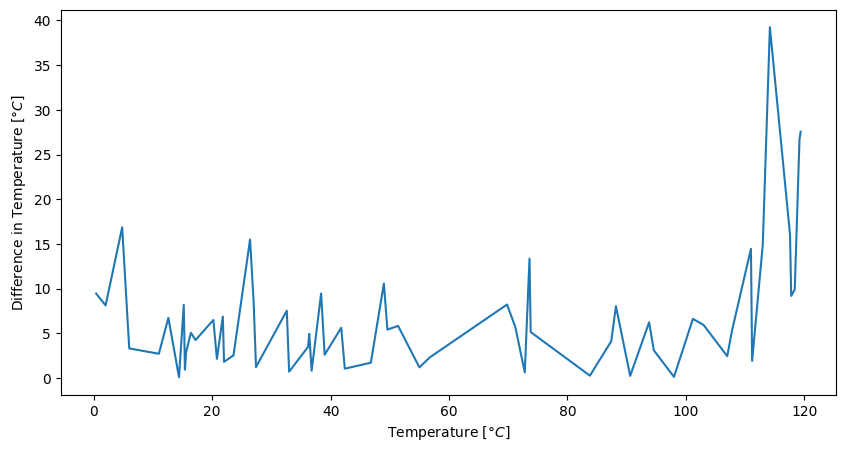

In [31]:
from sklearn.model_selection import train_test_split

X, y = dataset.numpy(raw=False)
N = X.shape[0]
V = X.shape[1]
X = torch.tensor(X).reshape(N * V, 1, sz[0], sz[1]).reshape(N * V, sz[0] * sz[1]).cpu().detach().numpy()
y = torch.tensor(y).unsqueeze(1).expand(-1, V).reshape(N * V, 1).squeeze(-1).cpu().detach().numpy()


X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.1, random_state=42)

lr_rg = LinearRegression()
lr_rg.fit(X_train, y_train)

y_pred = lr_rg.predict(X_test)


# print r2 score and predictions
print("#######################################")
print(f"Actual temperatures:\t\t{y_test[:5]}")
print(f"Predicted temperatures:\t\t{y_pred[:5]}")
print(f"R2: {r2_score(y_test, y_pred)}")
print(f"MSE: {np.mean((y_test - y_pred) ** 2)}, RMSE: {np.sqrt(np.mean((y_test - y_pred) ** 2))}")
print(f"MAE: {np.mean(np.abs(y_test - y_pred))}")

# print out differences per temperature
# Get the sorting indices from the first vector
idxs = np.argsort(y_test)

# Sort both vectors using the sorting indices
xx = y_test[idxs]
yy = np.abs(y_test - y_pred)[idxs]


plt.figure(figsize=[10, 5])
plt.plot(xx, yy)
plt.xlabel(f"Temperature [$\degree C$]")
plt.ylabel(f"Difference in Temperature [$\degree C$]")
plt.show()